# Triple Barrier

Test labeling if one trade

In [39]:
import pandas as pd
import sys
sys.path.append("../../")

## Constants

In [40]:
PIP_DECIMAL_POSITION: int = 4

## Data Prerequisites

This section describes how to prepare data before using triple barrier

In [41]:
df = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, index_col=[0])
df.head(5)

,Open,High,Low,Close,Volume
Time (America/Buenos_Aires),,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


## Example 1

**Scenario Description**

This scenario describes how to label a trade with the following features:

- Instrument: EUR/USD
- Time frame: 5m
- Side: Long (Buy)
- Stop loss: 5 pips below opening price
- Take profit: 10 pips above opening price.
- Open date/time: "2023-01-02 20:45:00"

NOTES:

- Stop loss and take profit can be passed as distance from opening price, in pips or as price levels. In this case both are defined as distance in pips.
- The library provides an enum type: TradeSide to specify the value of the trade direction or side as BUY or SELL.
- The EUR/USD pip decimal position is at the fourth digit, which is specified as 4 (PIP_DECIMAL_POSITION)
- All the trade related values are set in a structure named Orders, which is passed to the Labeler constructor along with the OHLC price time series.
- It was chosen to pass the OHLC time series separately, regardless CLEAN code recommendations,  having in mind that eventually it would be necessary to implement Buy on Bid, close on Ask setup, which would be a problem with an OHLC vector because generally all components are either bid or ask.


In [42]:
from dateutil import parser
from triple_barrier.trade_labeling import (TradeSide,
                                           OrderType,
                                           Labeler,
                                           )
from triple_barrier.trade_labeling import Orders

box_setup = Orders()

box_setup.open_time = "2023-01-02 20:45:00"
box_setup.open_price = df.loc[box_setup.open_time]["Open"]
box_setup.take_profit_width = 10
box_setup.stop_loss_width = 5
box_setup.time_limit = df[box_setup.open_time:].index[10]
box_setup.trade_side = TradeSide.BUY
box_setup.pip_decimal_position = 4

It is possible to print the box_setup like so:

In [43]:
print(box_setup)


        open time: 2023-01-02 20:45:00
        open price: 1.06709
        trade side: BUY
        stop loss : 5
        take profit : 10
        time limit : 2023-01-02 21:35:00
        pip position : 4
        


In [44]:
trade_labeler = Labeler(open_price=df.Open,
                               high_price=df.High,
                               low_price=df.Low,
                               close_price=df.Close,
                               box_setup=box_setup)
orders_hit = trade_labeler.compute()

It is possible to assign the orders outcome, which contains when each order was hit and the first order hit (the one that closed the position). It is also get the same values from the Labeler attribute: orders_hit

In [45]:
orders_hits = [str(hit) for hit in orders_hit.barriers]
for hit in orders_hits:
    print(hit)
print("Closing order hit ", orders_hit.first_hit)


        Datetime: 2023-01-09 02:25:00
        Level: 1.06809
        Type: take-profit
        

        Datetime: 2023-01-02 22:00:00
        Level: 1.0665900000000001
        Type: stop-loss
        

        Datetime: 2023-01-02 21:35:00
        Level: 1.0671
        Type: time-expiration
        
Closing order hit  
        Datetime: 2023-01-02 21:35:00
        Level: 1.0671
        Type: time-expiration
        


The same can carried out querying the Labeler structure: orders_hit, like so

In [46]:
orders_hits = [str(hit) for hit in trade_labeler.orders_hit.barriers]
for hit in orders_hits:
    print(hit)
print("Closing order hit ", orders_hit.first_hit)


        Datetime: 2023-01-09 02:25:00
        Level: 1.06809
        Type: take-profit
        

        Datetime: 2023-01-02 22:00:00
        Level: 1.0665900000000001
        Type: stop-loss
        

        Datetime: 2023-01-02 21:35:00
        Level: 1.0671
        Type: time-expiration
        
Closing order hit  
        Datetime: 2023-01-02 21:35:00
        Level: 1.0671
        Type: time-expiration
        


Not that complicated, isn't it?.

In [47]:
from triple_barrier.plots import PlotTripleBarrier
import mplfinance as mpl

Plotting the raw price first.

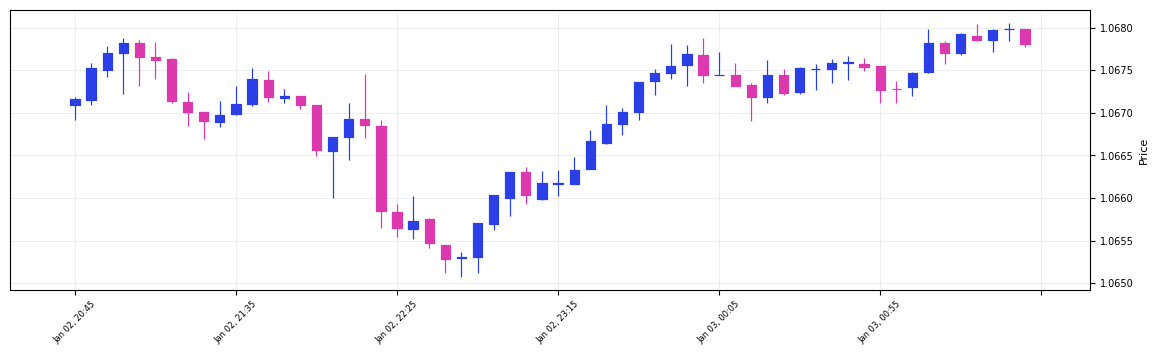

In [34]:
mpl.plot(df.loc[ "2023-01-02 20:45:00": "2023-01-03 01:40:00"], type="candle", figsize=(15,4), style="ibd")

In the constructor, same way as trade labeler are passed the OHLC time series, the instrument pip decimal position and how many periods to plot (default is 50)

In [28]:
plot_tb = PlotTripleBarrier(df.Open,
                           df.High,
                           df.Low,
                           df.Close,
                           PIP_DECIMAL_POSITION,
                           periods_to_plot=60
                           )

Now plot the full Orders Box in the same dataset plotted above. The inverted triangle indicates when the position was closed, in this case the closing event was because the expiration time was reached.

Plotting barrier for 60


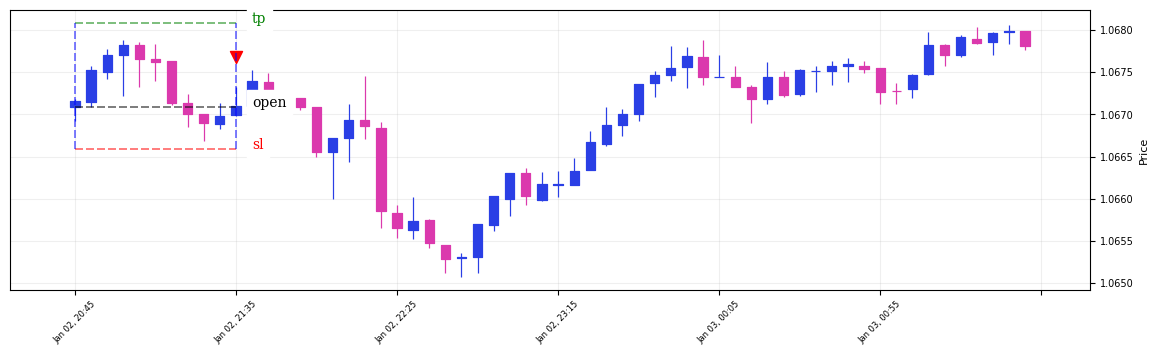

In [29]:
plot_tb.plot_multi_barrier(trade_labeler)